# Creating and Evaluating Predictors: Part 1 - Target Time Series

This notebook will build off of the earlier data processing that was performed in the validation sessions. If you have not completed that part yet, go back to [1.Validate_and_Import_Target_Time_Series_Data.ipynb](1.Validate_and_Import_Target_Time_Series_Data.ipynb) and complete it first before resuming.

At this point you have target-time-series data loaded into Amazon Forecast inside a Dataset Group, this is what is required to use all of the models within Amazon Forecast. As an initial exploration we will evaluate the results from ARIMA, Prophet, and DeepAR+. We could have also included ETS or CNN-QR, but have left them out for time constraints. Similarly NPTS was left out as it specializes on spiky data or large gaps which our dataset does not have.

The very first thing to do is start with our imports, establish a connection to the Forecast service, and then restore our variables from before. The cells below will do that.

In [1]:
%load_ext autoreload
%autoreload 2

# Python Built-Ins:
import json
import os
from pprint import pprint as prettyprint
import time
from types import SimpleNamespace  # (because Python dict ["key"] notation can get boring)

# External Dependencies:
import boto3
from IPython.display import Markdown
import pandas as pd

# Local Dependencies:
import util

In [2]:
%store -r

In [3]:
session = boto3.Session(region_name=region)

forecast = session.client("forecast")
forecast_query = session.client("forecastquery")

s3 = session.resource("s3")
export_bucket = s3.Bucket(export_bucket_name)

## Creating and Training Predictors
 
Given that that our data is hourly and we want to generate a forecast on the hour, Forecast limits us to a horizon of 500 of whatever the slice is. This means we will be able to predict about 20 days into the future.

The cells below will define a few variables to be used with all of our models. We'll then re-use these to create each `Predictor` we investigate.


In [4]:
# Baseline/statistical methods:
arima_algorithm_arn = "arn:aws:forecast:::algorithm/ARIMA"
ets_algorithm_arn = "arn:aws:forecast:::algorithm/ETS"

# Probabilistic methods:
npts_algorithm_arn = "arn:aws:forecast:::algorithm/NPTS"
prophet_algorithm_arn = "arn:aws:forecast:::algorithm/Prophet"

# Deep learning methods:
deeparp_algorithm_arn = "arn:aws:forecast:::algorithm/Deep_AR_Plus"
cnnqr_algorithm_arn = "arn:aws:forecast:::algorithm/CNN-QR"

# Set up our top-level results dict:
results = {}

In [5]:
forecast_horizon = 240
forecast_frequency = "H"
evaluation_parameters = {
    "NumberOfBacktestWindows": 1,
    "BackTestWindowOffset": 240,
}
input_data_config = {
    "DatasetGroupArn": datasetGroupArn,
    "SupplementaryFeatures": [
        { "Name": "holiday", "Value": "US" },
    ],
}

### ARIMA

In [6]:
arima_create_predictor_response = forecast.create_predictor(
    PredictorName=f"{project}_arima_algo_1",
    AlgorithmArn=arima_algorithm_arn,
    ForecastHorizon=forecast_horizon,
    PerformAutoML=False,
    PerformHPO=False,
    EvaluationParameters=evaluation_parameters,
    InputDataConfig=input_data_config,
    FeaturizationConfig={
        "ForecastFrequency": forecast_frequency,
        "Featurizations": [
            {
                "AttributeName": "target_value",
                "FeaturizationPipeline": [
                    {
                        "FeaturizationMethodName": "filling",
                        "FeaturizationMethodParameters": {
                            "frontfill": "none",
                            "middlefill": "zero",
                            "backfill": "zero",
                        },
                    },
                ],
            },
        ],
    },
)
results["ARIMA"] = SimpleNamespace(predictor_arn=arima_create_predictor_response["PredictorArn"])

### Prophet

In [7]:
prophet_create_predictor_response = forecast.create_predictor(
    PredictorName=f"{project}_prophet_algo_1",
    AlgorithmArn=prophet_algorithm_arn,
    ForecastHorizon=forecast_horizon,
    PerformAutoML=False,
    PerformHPO=False,
    EvaluationParameters=evaluation_parameters,
    InputDataConfig=input_data_config,
    FeaturizationConfig={
        "ForecastFrequency": forecast_frequency, 
        "Featurizations": [
            {
                "AttributeName": "target_value",
                "FeaturizationPipeline": [
                    {
                        "FeaturizationMethodName": "filling",
                        "FeaturizationMethodParameters": {
                            "frontfill": "none",
                            "middlefill": "zero",
                            "backfill": "zero",
                        },
                    },
                ],
            },
        ],
    },
)
results["Prophet"] = SimpleNamespace(predictor_arn=prophet_create_predictor_response["PredictorArn"])

### DeepAR+

In [8]:
deeparp_create_predictor_response = forecast.create_predictor(
    PredictorName=f"{project}_deeparp_algo_1",
    AlgorithmArn=deeparp_algorithm_arn,
    ForecastHorizon=forecast_horizon,
    PerformAutoML=False,
    PerformHPO=False,
    EvaluationParameters=evaluation_parameters,
    InputDataConfig=input_data_config,
    FeaturizationConfig={
        "ForecastFrequency": forecast_frequency, 
        "Featurizations": [
            {
                "AttributeName": "target_value",
                "FeaturizationPipeline": [
                    {
                        "FeaturizationMethodName": "filling",
                        "FeaturizationMethodParameters": {
                            "frontfill": "none",
                            "middlefill": "zero",
                            "backfill": "zero",
                        },
                    },
                ],
            },
        ],
    },
)
results["DeepAR+"] = SimpleNamespace(predictor_arn=deeparp_create_predictor_response["PredictorArn"])

### CNN-QR

In [11]:
cnnqr_create_predictor_response = forecast.create_predictor(
    PredictorName=f"{project}_cnnqr_algo_1",
    AlgorithmArn=cnnqr_algorithm_arn,
    ForecastHorizon=forecast_horizon,
    PerformAutoML=False,
    PerformHPO=False,
    EvaluationParameters=evaluation_parameters,
    InputDataConfig=input_data_config,
    FeaturizationConfig={
        "ForecastFrequency": forecast_frequency, 
        "Featurizations": [
            {
                "AttributeName": "target_value",
                "FeaturizationPipeline": [
                    {
                        "FeaturizationMethodName": "filling",
                        "FeaturizationMethodParameters": {
                            "frontfill": "none",
                            "middlefill": "zero",
                            "backfill": "zero",
                        },
                    },
                ],
            },
        ],
    },
)
results["CNN-QR"] = SimpleNamespace(predictor_arn=cnnqr_create_predictor_response["PredictorArn"])

Normally in our notebooks we would have a while loop that polls for each of these to determine the status of the models in training. The cell below will poll for the ARNs of each and return when they are all available so you can move onto the next step.

In [12]:
in_progress_predictors = [results[r].predictor_arn for r in results]
failed_predictors = []

def check_status():
    """Check and update in_progress_predictors"""
    just_stopped = []  # Can't edit the in_progress list directly the loop!
    for arn in in_progress_predictors:
        predictor_desc = forecast.describe_predictor(PredictorArn=arn)
        status = predictor_desc["Status"]
        if status == "ACTIVE":
            print(f"\nBuild succeeded for {arn}")
            just_stopped.append(arn)
        elif "FAILED" in status:
            print(f"\nBuild failed for {arn}")
            just_stopped.append(arn)
            failed_predictors.append(arn)
    for arn in just_stopped:
        in_progress_predictors.remove(arn)
    return in_progress_predictors

util.progress.polling_spinner(
    fn_poll_result=check_status,
    fn_is_finished=lambda l: len(l) == 0,
    fn_stringify_result=lambda l: f"{len(l)} predictor builds in progress",
    poll_secs=60,  # Poll every minute
    timeout_secs=3*60*60,  # Max 3 hours
)

if len(failed_predictors):
    raise RuntimeError(f"The following predictors failed to train:\n{failed_predictors}")


Build succeeded for arn:aws:forecast:ap-southeast-1:024103970757:predictor/forecast_poc_rkyc_arima_algo_1

Build succeeded for arn:aws:forecast:ap-southeast-1:024103970757:predictor/forecast_poc_rkyc_prophet_algo_1
Initial status: 2 predictor builds in progress
\ Status: 2 predictor builds in progress [Since: relativedelta(minutes=+36, seconds=+7)] 
Build succeeded for arn:aws:forecast:ap-southeast-1:024103970757:predictor/forecast_poc_rkyc_deeparp_algo_1

\ Status: 1 predictor builds in progress [Since: relativedelta(hours=+1, minutes=+11, seconds=+12)]
Build succeeded for arn:aws:forecast:ap-southeast-1:024103970757:predictor/forecast_poc_rkyc_cnnqr_algo_1

| Status: 0 predictor builds in progress [Since: relativedelta()]                                  


## Examining the Predictors

Once each of the Predictors is in an `Active` state you can get metrics about it to better understand its accuracy and behavior. These are computed based on the hold out periods we defined when building the Predictor. The metrics are meant to guide our decisions when we use a particular Predictor to generate a forecast.

Below we'll define a utility function below which retrieves (and prints) the raw accuracy metrics response, and also builds up a leaderboard. In the following cells, we'll run the function against each trained predictor.

In [13]:
def evaluate_trial_metrics(trial_name=None) -> pd.DataFrame:
    """Utility to fetch the accuracy metrics for a predictor and output the leaderboard so far"""
    if (trial_name):
        # Print the raw API response:
        metrics_response = forecast.get_accuracy_metrics(PredictorArn=results[trial_name].predictor_arn)
        print(f"Raw metrics for {trial_name}:")
        prettyprint(metrics_response)

        # Save the payload section to results:
        evaluation_results = metrics_response["PredictorEvaluationResults"]
        results[trial_name].evaluation_results = evaluation_results

        # Construct simplified version for our comparison:
        try:
            summary_metrics = next(
                w for w in evaluation_results[0]["TestWindows"] if w["EvaluationType"] == "SUMMARY"
            )["Metrics"]
        except StopIteration:
            raise ValueError("Couldn't find SUMMARY metrics in Forecast API response")
        results[trial_name].summary_metrics = {
            "RMSE": summary_metrics["RMSE"],
            "10% wQL": next(
                l["LossValue"] for l in summary_metrics["WeightedQuantileLosses"] if l["Quantile"] == 0.1
            ),
            "50% wQL (MAPE)": next(
                l["LossValue"] for l in summary_metrics["WeightedQuantileLosses"] if l["Quantile"] == 0.5
            ),
            "90% wQL": next(
                l["LossValue"] for l in summary_metrics["WeightedQuantileLosses"] if l["Quantile"] == 0.9
            ),
        }
    # Render the leaderboard:
    return pd.DataFrame([
        { "Predictor": name, **results[name].summary_metrics } for name in results
        if "summary_metrics" in results[name].__dict__
    ]).set_index("Predictor")

### ARIMA

ARIMA is one of the gold standards for time series forecasting. This algorithm is not particularly sophisticated but it is reliable and can help us understand a baseline of performance. To note it does not really understand seasonality very well and it does not support any item metadata or related time series information. Due to that we will explore it here but not after adding other datasets.

In [14]:
evaluate_trial_metrics("ARIMA")

Raw metrics for ARIMA:
{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/ARIMA',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 1947.4273267312885,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.2856584745035964,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.4708293294692129,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.17062988246313263,
                                                                                          'Quantile': 0.1}]}},
                        

,RMSE,10% wQL,50% wQL (MAPE),90% wQL
Predictor,,,,
ARIMA,1947.427327,0.17063,0.470829,0.285658


In our test, ARIMA scored a RMSE of ~1950 and 50% weighted quantile loss (=MAPE) of ~0.4715. ARIMA results will help us benchmark other predictors, looking for a reduction versus these baseline loss figures. Your results may vary a little across the predictors.

### Prophet

As with ARIMA, let's explore the metrics:

In [15]:
evaluate_trial_metrics("Prophet")

Raw metrics for Prophet:
{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 1890.3662853859607,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.2627370909646454,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.48301195328139007,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.18972975832322458,
                                                                                          'Quantile': 0.1}]}},
                   

,RMSE,10% wQL,50% wQL (MAPE),90% wQL
Predictor,,,,
ARIMA,1947.427327,0.17063,0.470829,0.285658
Prophet,1890.366285,0.18973,0.483012,0.262737


In our test, Prophet achieved a slightly lower RMSE than ARIMA at around 1910 - but the weighted quantile losses were pretty similar and worse on some quantiles.

At this point, Prophet has not had a chance to use any of its abilities to integrate related time-series information since only the target time-series has been uploaded.

### DeepAR+

As with Prophet and ARIMA, let's explore the metrics:

In [16]:
evaluate_trial_metrics("DeepAR+")

Raw metrics for DeepAR+:
{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 1565.1929659103587,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.21416452568268046,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.3591633218949527,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.21958383504854267,
                                                                                          'Quantile': 0.1}]}},
              

,RMSE,10% wQL,50% wQL (MAPE),90% wQL
Predictor,,,,
ARIMA,1947.427327,0.170630,0.470829,0.285658
Prophet,1890.366285,0.189730,0.483012,0.262737
DeepAR+,1565.192966,0.219584,0.359163,0.214165


In our test, DeepAR+ achieved a significant improvement in accuracy as measured both by RMSE (~1570) and at the 50% and 90% quantiles. The 10% quantile showed somewhat poorer performance, but overall accuracy was still good.

To see what all this looks like in a visual format, we'll now create a Forecast with each Predictor and then export them to S3 to explore.

### CNN-QR

In [17]:
evaluate_trial_metrics("CNN-QR")

Raw metrics for CNN-QR:
{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/CNN-QR',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 1730.1345766266938,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.22141778448396063,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.3842355500422395,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.14133197549248033,
                                                                                          'Quantile': 0.1}]}},
                     

,RMSE,10% wQL,50% wQL (MAPE),90% wQL
Predictor,,,,
ARIMA,1947.427327,0.170630,0.470829,0.285658
Prophet,1890.366285,0.189730,0.483012,0.262737
DeepAR+,1565.192966,0.219584,0.359163,0.214165
CNN-QR,1730.134577,0.141332,0.384236,0.221418


## Creating and Exporting Forecasts

Inside Amazon Forecast a Forecast is a rendered collection of all of your items, at every time interval, for all selected quantiles, for your given forecast horizon. This process takes the Predictor you just created and uses it to generate these inferences and to store them in a useful state. Once a Forecast exists within the service you can query it and obtain a JSON response or use another API call to export it to a CSV that is stored in S3. 

This tutorial will focus on the S3 Export as that is often an easy way to manually explore the data with many tools.

These again will take some time to complete after you have executed the cells so explore the console to see when they have completed.

To do that visit the Amazon Forecast Service page, then clck your Dataset Group, and then click `Forecasts` on the left. They will say `Create in progress...` initially and then `Active` when ready for export.

In [18]:
create_forecast_response = forecast.create_forecast(
    ForecastName=f"{project}_arima_algo_forecast",
    PredictorArn=results["ARIMA"].predictor_arn,
)
results["ARIMA"].forecast_arn = create_forecast_response["ForecastArn"]

In [19]:
create_forecast_response = forecast.create_forecast(
    ForecastName=f"{project}_prophet_algo_forecast",
    PredictorArn=results["Prophet"].predictor_arn,
)
results["Prophet"].forecast_arn = create_forecast_response["ForecastArn"]

In [21]:
create_forecast_response = forecast.create_forecast(
    ForecastName=f"{project}_deeparp_algo_forecast",
    PredictorArn=results["DeepAR+"].predictor_arn,
)
results["DeepAR+"].forecast_arn = create_forecast_response["ForecastArn"]

In [22]:
create_forecast_response = forecast.create_forecast(
    ForecastName=f"{project}_cnnqr_algo_forecast",
    PredictorArn=results["CNN-QR"].predictor_arn,
)
results["CNN-QR"].forecast_arn = create_forecast_response["ForecastArn"]

Again as you saw in the training step, you should poll until completion to know that you are ready to proceed to the next step. The cell below will do that.

In [23]:
#in_progress_forecasts = [results[r].forecast_arn for r in results]
in_progress_forecasts = []
for r in results:
    try:
        in_progress_forecasts.append(results[r].forecast_arn)
    except:
        pass
failed_forecasts = []

def check_status():
    """Check and update in_progress_forecasts"""
    just_stopped = []  # Can't edit the in_progress list directly the loop!
    for arn in in_progress_forecasts:
        desc_response = forecast.describe_forecast(ForecastArn=arn)
        status = desc_response["Status"]
        if status == "ACTIVE":
            print(f"\nBuild succeeded for {arn}")
            just_stopped.append(arn)
        elif "FAILED" in status:
            print(f"\nBuild failed for {arn}")
            just_stopped.append(arn)
            failed_forecasts.append(arn)
    for arn in just_stopped:
        in_progress_forecasts.remove(arn)
    return in_progress_forecasts

util.progress.polling_spinner(
    fn_poll_result=check_status,
    fn_is_finished=lambda l: len(l) == 0,
    fn_stringify_result=lambda l: f"{len(l)} forecast builds in progress",
    poll_secs=60,  # Poll every 60s
    timeout_secs=2*60*60,  # Max 2 hours
)

if len(failed_forecasts):
    raise RuntimeError(f"The following forecasts failed:\n{failed_forecasts}")


Build succeeded for arn:aws:forecast:ap-southeast-1:024103970757:forecast/forecast_poc_rkyc_arima_algo_forecast

Build succeeded for arn:aws:forecast:ap-southeast-1:024103970757:forecast/forecast_poc_rkyc_prophet_algo_forecast
Initial status: 2 forecast builds in progress
\ Status: 2 forecast builds in progress [Since: relativedelta(minutes=+59, seconds=+14)]
Build succeeded for arn:aws:forecast:ap-southeast-1:024103970757:forecast/forecast_poc_rkyc_deeparp_algo_forecast

\ Status: 1 forecast builds in progress [Since: relativedelta(minutes=+52, seconds=+9)] 
Build succeeded for arn:aws:forecast:ap-southeast-1:024103970757:forecast/forecast_poc_rkyc_cnnqr_algo_forecast

| Status: 0 forecast builds in progress [Since: relativedelta()]                        


Once they are `Active` you can start the export process. The code to do so is in the cells below. 

In [24]:
export_response = forecast.create_forecast_export_job(
    ForecastExportJobName="arima_export",
    ForecastArn=results["ARIMA"].forecast_arn,
    Destination={
        "S3Config": {
            "Path": f"s3://{export_bucket_name}/arima/01_TTS_Only/",
            "RoleArn": forecast_role_arn,
        },
    },
)
results["ARIMA"].export_arn = export_response["ForecastExportJobArn"]

In [25]:
export_response = forecast.create_forecast_export_job(
    ForecastExportJobName="prophet_export",
    ForecastArn=results["Prophet"].forecast_arn,
    Destination={
        "S3Config": {
            "Path": f"s3://{export_bucket_name}/prophet/01_TTS_Only/",
            "RoleArn": forecast_role_arn,
        },
    },
)
results["Prophet"].export_arn = export_response["ForecastExportJobArn"]

In [27]:
export_response = forecast.create_forecast_export_job(
    ForecastExportJobName="deeparp_export",
    ForecastArn=results["DeepAR+"].forecast_arn,
    Destination={
        "S3Config": {
            "Path": f"s3://{export_bucket_name}/deeparp/01_TTS_Only/",
            "RoleArn": forecast_role_arn,
        },
    },
)
results["DeepAR+"].export_arn = export_response["ForecastExportJobArn"]

In [28]:
export_response = forecast.create_forecast_export_job(
    ForecastExportJobName="cnnqr_export",
    ForecastArn=results["CNN-QR"].forecast_arn,
    Destination={
        "S3Config": {
            "Path": f"s3://{export_bucket_name}/cnnqr/01_TTS_Only/",
            "RoleArn": forecast_role_arn,
        },
    },
)
results["CNN-QR"].export_arn = export_response["ForecastExportJobArn"]

This exporting process is another one of those items that will take several minutes to complete. Once again, poll with the cell below then move on to the next section.

In [29]:
#in_progress_exports = [results[r].export_arn for r in results]
in_progress_exports = []
for r in results:
    try:
        in_progress_exports.append(results[r].export_arn)
    except:
        pass
failed_exports = []

def check_status():
    """Check and update in_progress_exports"""
    just_stopped = []  # Can't edit the in_progress list directly the loop!
    for arn in in_progress_exports:
        desc_response = forecast.describe_forecast_export_job(ForecastExportJobArn=arn)
        status = desc_response["Status"]
        if status == "ACTIVE":
            print(f"\nExport succeeded for {arn}")
            just_stopped.append(arn)
        elif "FAILED" in status:
            print(f"\nExport failed for {arn}")
            just_stopped.append(arn)
            failed_exports.append(arn)
    for arn in just_stopped:
        in_progress_exports.remove(arn)
    return in_progress_exports

util.progress.polling_spinner(
    fn_poll_result=check_status,
    fn_is_finished=lambda l: len(l) == 0,
    fn_stringify_result=lambda l: f"{len(l)} forecast exports in progress",
    poll_secs=20,  # Poll every 20s
    timeout_secs=60*60,  # Max 1 hour
)

if len(failed_exports):
    raise RuntimeError(f"The following exports failed:\n{failed_exports}")


Export succeeded for arn:aws:forecast:ap-southeast-1:024103970757:forecast-export-job/forecast_poc_rkyc_arima_algo_forecast/arima_export

Export succeeded for arn:aws:forecast:ap-southeast-1:024103970757:forecast-export-job/forecast_poc_rkyc_prophet_algo_forecast/prophet_export
Initial status: 2 forecast exports in progress
/ Status: 2 forecast exports in progress [Since: relativedelta(minutes=+1, seconds=+40)]
Export succeeded for arn:aws:forecast:ap-southeast-1:024103970757:forecast-export-job/forecast_poc_rkyc_deeparp_algo_forecast/deeparp_export

Export succeeded for arn:aws:forecast:ap-southeast-1:024103970757:forecast-export-job/forecast_poc_rkyc_cnnqr_algo_forecast/cnnqr_export

- Status: 0 forecast exports in progress [Since: relativedelta()]                       


### Downloading the Exports

Once our forecasts are exported to Amazon S3, we can download them locally to the notebook for analysis and plotting.

Although [Boto3 S3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html) provides functions for listing and fetching files, we'll simplify the process a bit by calling the `aws s3 sync` command from the [AWS CLI](https://aws.amazon.com/cli/).

Note that large exports may split output into multiple files, so here we store *lists* of filenames for each export.

In [30]:
job_desc = forecast.describe_forecast_export_job(ForecastExportJobArn=results["ARIMA"].export_arn)
s3uri = job_desc["Destination"]["S3Config"]["Path"]
local_folder = f"data/exports/{job_desc['ForecastExportJobName']}"

!aws s3 sync $s3uri $local_folder

results["ARIMA"].local_filenames = sorted(list(map(
    lambda file: f"{local_folder}/{file}",
    filter(lambda file: file.endswith(".csv"), os.listdir(local_folder)),
)))

download: s3://024103970757-forecastpoc-7a1kn9w9/arima/01_TTS_Only/arima_export_2020-08-30T03-11-08Z_part1.csv to data/exports/arima_export/arima_export_2020-08-30T03-11-08Z_part1.csv
download: s3://024103970757-forecastpoc-7a1kn9w9/arima/01_TTS_Only/arima_export_2020-08-30T03-11-08Z_part0.csv to data/exports/arima_export/arima_export_2020-08-30T03-11-08Z_part0.csv


In [31]:
job_desc = forecast.describe_forecast_export_job(ForecastExportJobArn=results["Prophet"].export_arn)
s3uri = job_desc["Destination"]["S3Config"]["Path"]
local_folder = f"data/exports/{job_desc['ForecastExportJobName']}"

!aws s3 sync $s3uri $local_folder

results["Prophet"].local_filenames = sorted(list(map(
    lambda file: f"{local_folder}/{file}",
    filter(lambda file: file.endswith(".csv"), os.listdir(local_folder)),
)))

download: s3://024103970757-forecastpoc-7a1kn9w9/prophet/01_TTS_Only/prophet_export_2020-08-30T03-10-38Z_part0.csv to data/exports/prophet_export/prophet_export_2020-08-30T03-10-38Z_part0.csv
download: s3://024103970757-forecastpoc-7a1kn9w9/prophet/01_TTS_Only/prophet_export_2020-08-30T03-10-38Z_part1.csv to data/exports/prophet_export/prophet_export_2020-08-30T03-10-38Z_part1.csv


In [32]:
job_desc = forecast.describe_forecast_export_job(ForecastExportJobArn=results["DeepAR+"].export_arn)
s3uri = job_desc["Destination"]["S3Config"]["Path"]
local_folder = f"data/exports/{job_desc['ForecastExportJobName']}"

!aws s3 sync $s3uri $local_folder

results["DeepAR+"].local_filenames = sorted(list(map(
    lambda file: f"{local_folder}/{file}",
    filter(lambda file: file.endswith(".csv"), os.listdir(local_folder)),
)))

download: s3://024103970757-forecastpoc-7a1kn9w9/deeparp/01_TTS_Only/deeparp_export_2020-08-30T03-18-15Z_part1.csv to data/exports/deeparp_export/deeparp_export_2020-08-30T03-18-15Z_part1.csv
download: s3://024103970757-forecastpoc-7a1kn9w9/deeparp/01_TTS_Only/deeparp_export_2020-08-30T03-18-15Z_part0.csv to data/exports/deeparp_export/deeparp_export_2020-08-30T03-18-15Z_part0.csv


In [33]:
job_desc = forecast.describe_forecast_export_job(ForecastExportJobArn=results["CNN-QR"].export_arn)
s3uri = job_desc["Destination"]["S3Config"]["Path"]
local_folder = f"data/exports/{job_desc['ForecastExportJobName']}"

!aws s3 sync $s3uri $local_folder

results["CNN-QR"].local_filenames = sorted(list(map(
    lambda file: f"{local_folder}/{file}",
    filter(lambda file: file.endswith(".csv"), os.listdir(local_folder)),
)))

download: s3://024103970757-forecastpoc-7a1kn9w9/cnnqr/01_TTS_Only/_CHECK to data/exports/cnnqr_export/_CHECK
download: s3://024103970757-forecastpoc-7a1kn9w9/cnnqr/01_TTS_Only/cnnqr_export_2020-08-30T03-18-12Z_part1.csv to data/exports/cnnqr_export/cnnqr_export_2020-08-30T03-18-12Z_part1.csv
download: s3://024103970757-forecastpoc-7a1kn9w9/cnnqr/01_TTS_Only/cnnqr_export_2020-08-30T03-18-12Z_part0.csv to data/exports/cnnqr_export/cnnqr_export_2020-08-30T03-18-12Z_part0.csv
download: s3://024103970757-forecastpoc-7a1kn9w9/cnnqr/01_TTS_Only/_SUCCESS to data/exports/cnnqr_export/_SUCCESS


## Validation

Now it's time to explore the downloaded results to plot the forecasts against our validation data and check the format is as expected.

> ⚠️ **Note:** Because our dataset is small, we'll just load a single (first) file from each export to simplify the code here... Be careful if re-using this code for bigger datasets!

### ARIMA

We'll take things slowly with our first (ARIMA) forecast to demonstrate the details, and then speed things up for the others.

First, let's take a look at the raw DataFrame as loaded by Pandas:

In [34]:
print(f"Loading {results['ARIMA'].local_filenames[0]}...")
arima_predicts = pd.read_csv(results["ARIMA"].local_filenames[0])
arima_predicts.sample()

Loading data/exports/arima_export/arima_export_2020-08-29T06-44-00Z_part0.csv...


,item_id,date,p10,p50,p90
83,all traffic,2018-01-04T11:00:00Z,2408.569976,4902.625588,7396.6812


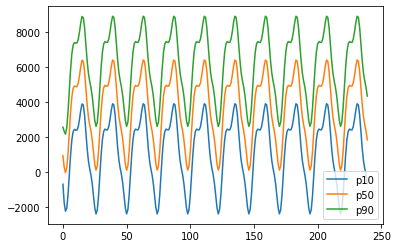

In [35]:
arima_predicts.plot()

We can tidy things up a bit by parsing the timestamps and indexing the dataframe by them:

In [36]:
# Convert the column to datetime
arima_predicts["date"] = pd.to_datetime(arima_predicts["date"])
arima_predicts.sample()

,item_id,date,p10,p50,p90
206,all traffic,2018-01-09 14:00:00+00:00,3542.224801,6036.280413,8530.336025


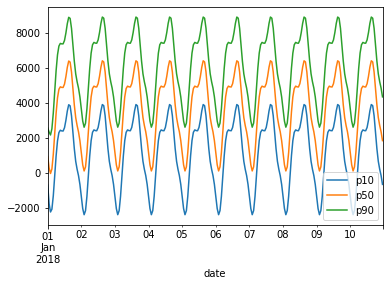

In [37]:
# Remove the timezone and make date the index
arima_predicts['date'] = arima_predicts['date'].dt.tz_convert(None)
arima_predicts.set_index('date', inplace=True)
arima_predicts.plot()

In [38]:
print(arima_predicts.index.min())
print(arima_predicts.index.max())

2018-01-01 00:00:00
2018-01-10 23:00:00


Here we can see our prediction goes from Jan 01 to Jan 10 as expected given our 240 interval forecast horizon. Also we can see the cyclical nature of the predictions over the entire timeframe.

To visualize our forecast against the validation data, it would be helpful to:

- Remove/deal with the `item_id` column (which is always constant for our our single-item sample data)
- Overlay the actual value from the validation data

Let's do that now:

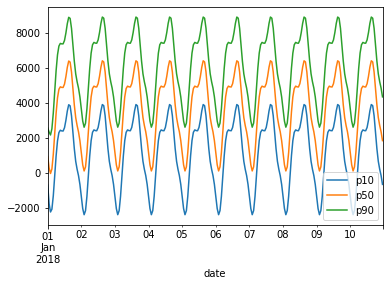

In [39]:
# Cut out item_id:
arima_simple = arima_predicts[['p10', 'p50', 'p90']]
arima_simple.plot()

2018-01-01 00:00:00
2018-01-10 23:00:00


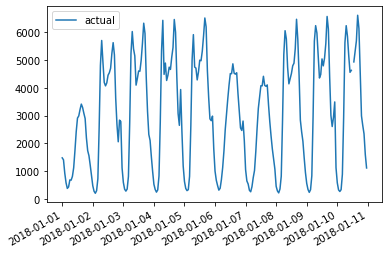

In [40]:
# Take the time window of validation data we'd like to overlay:
validation_df = validation_time_series_df.rename(columns={"traffic_volume": "actual"}).loc["2018-01-01":"2018-01-10"]
print(validation_df.index.min())
print(validation_df.index.max())
validation_df.plot()

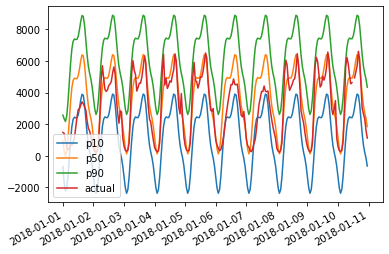

In [41]:
# Join the dataframes together:
arima_val_df = arima_simple.join(validation_df, how="outer")
arima_val_df.plot()

Given that this particular plot is hard to see, let us pick a random day January 5th to compare.

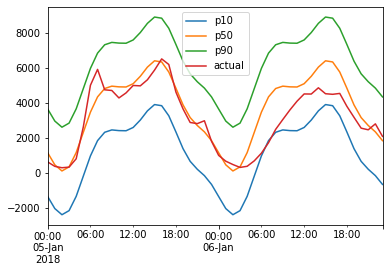

In [42]:
arima_val_df.loc["2018-01-05":"2018-01-06"].plot()

As we can see the actual traffic tracks quite closely to the p50 median prediction, and should stay within the p10-p90 band for most or all of the forecast horizon.

As a final step, we've implemented a utility function to improve the clarity a little further by expanding the plot area and plotting the p10/p90 interval as a **confidence interval** rather than independent lines.

Check you're comfortable with the plot below, and then we'll move on to comparing ARIMA with our other predictors:

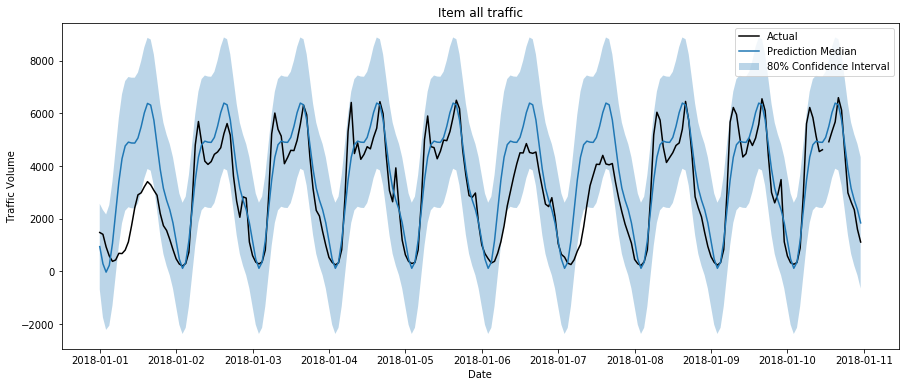

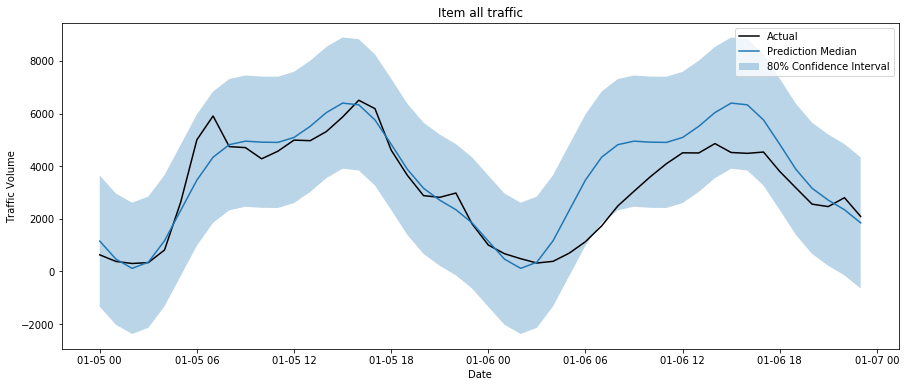

In [47]:
util.plot_forecasts(arima_predicts, actuals=validation_df, ylabel="Traffic Volume")

util.plot_forecasts(
    arima_predicts["2018-01-05":"2018-01-06"],
    actuals=validation_df["2018-01-05":"2018-01-06"],
    ylabel="Traffic Volume"
)

### Prophet

Loading data/exports/prophet_export/prophet_export_2020-08-29T06-44-24Z_part0.csv...


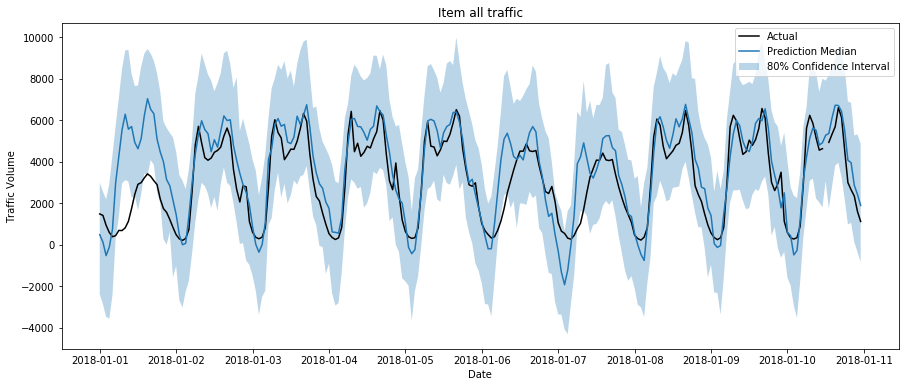

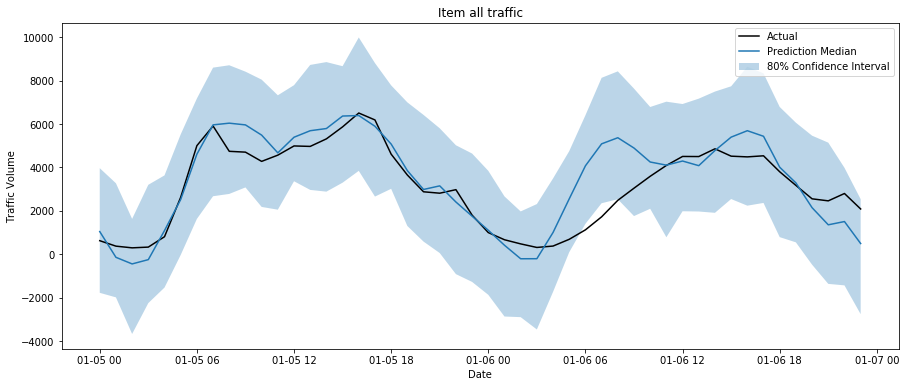

In [48]:
print(f"Loading {results['Prophet'].local_filenames[0]}...")
prophet_predicts = pd.read_csv(results["Prophet"].local_filenames[0])

# Set up date index:
prophet_predicts["date"] = pd.to_datetime(prophet_predicts["date"]).dt.tz_convert(None)
prophet_predicts.set_index("date", inplace=True)

util.plot_forecasts(prophet_predicts, actuals=validation_df, ylabel="Traffic Volume")

util.plot_forecasts(
    prophet_predicts.loc["2018-01-05":"2018-01-06"],
    actuals=validation_df.loc["2018-01-05":"2018-01-06"],
    ylabel="Traffic Volume"
)

### DeepAR+

Loading data/exports/deeparp_export/deeparp_export_2020-08-29T06-44-34Z_part0.csv...


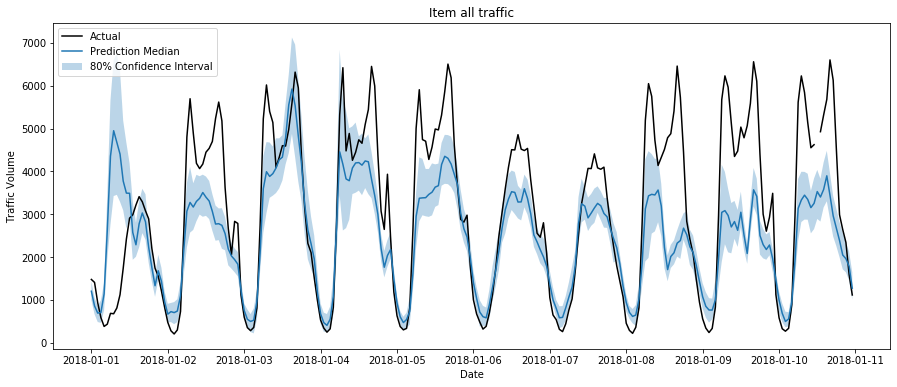

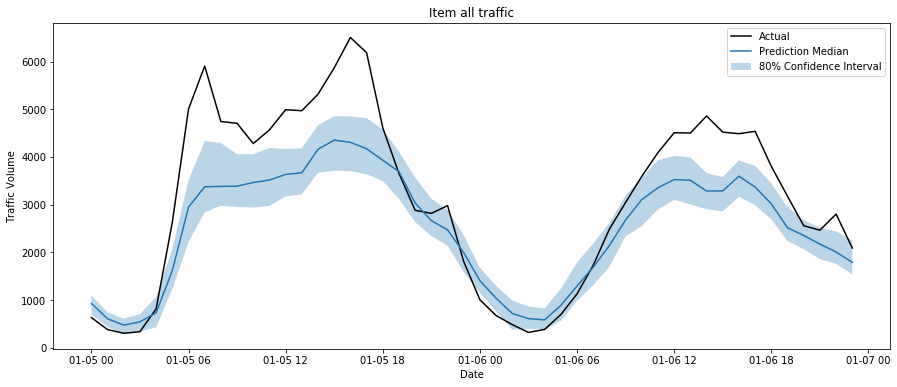

In [49]:
print(f"Loading {results['DeepAR+'].local_filenames[0]}...")
deeparp_predicts = pd.read_csv(results["DeepAR+"].local_filenames[0])

# Set up date index:
deeparp_predicts["date"] = pd.to_datetime(deeparp_predicts["date"]).dt.tz_convert(None)
deeparp_predicts.set_index("date", inplace=True)

util.plot_forecasts(deeparp_predicts, actuals=validation_df, ylabel="Traffic Volume")

util.plot_forecasts(
    deeparp_predicts.loc["2018-01-05":"2018-01-06"],
    actuals=validation_df.loc["2018-01-05":"2018-01-06"],
    ylabel="Traffic Volume"
)

What is particularly interesting here is that even the p90 prediction is significantly below the actual numbers for a good portion of some days.

Consider how the evaluation metrics of these algorithms relate to the observed performance characteristics in the validation plots. Clearly for probabilistic forecasts, central metrics like RMSE and MAPE/wQL0.5 tell only part of the story of model accuracy - and this is why additional quantile loss metrics are presented.

Note that different algorithms generate quantiles by different methods. In particular, CNN-QR does not guarantee the ordering of quantiles (although good-quality fits should converge towards quantiles being ordered) - so there might be brief periods where e.g. the `p10` forecast quantile is higher than `p50`!

### CNN-QR

Loading data/exports/cnnqr_export/cnnqr_export_2020-08-30T03-18-12Z_part0.csv...


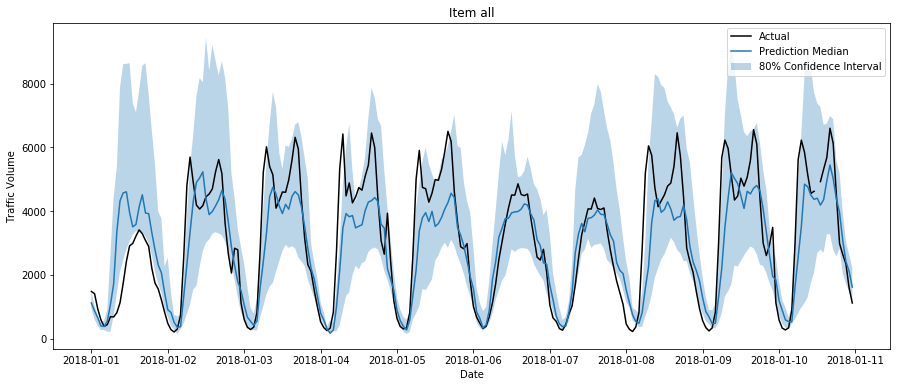

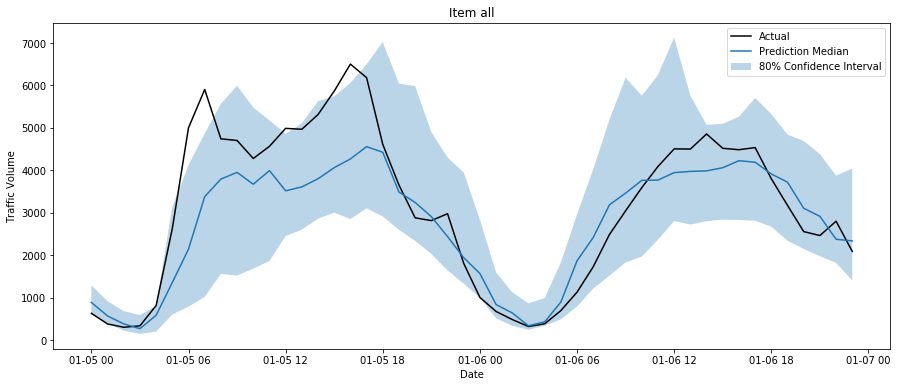

In [53]:
print(f"Loading {results['CNN-QR'].local_filenames[0]}...")
cnnqr_predicts = pd.read_csv(results["CNN-QR"].local_filenames[0])

# Set up date index:
cnnqr_predicts["date"] = pd.to_datetime(cnnqr_predicts["date"]).dt.tz_convert(None)
cnnqr_predicts.set_index("date", inplace=True)

util.plot_forecasts(cnnqr_predicts, actuals=validation_df, ylabel="Traffic Volume")

util.plot_forecasts(
    cnnqr_predicts.loc["2018-01-05":"2018-01-06"],
    actuals=validation_df.loc["2018-01-05":"2018-01-06"],
    ylabel="Traffic Volume"
)

## Recap and Next Steps

We've now explored some initial models on the target timeseries alone, and can start exploring additional **related data** as a way to improve forecast accuracy. The next notebook will guide you through the process of importing some *related time-series*.

In [54]:
%store results

Stored 'results' (dict)
